lmfit Version
===

Extracting a signal from two datasets.
---
Below we simulate two experiments.

Experiment1:
- has a gaussian signal
- and a falling background that goes as $exp^{-x/\lambda}$

Experinemt2:
- has the same gaussian signal component
- and a background that goes as $x^n$, where $n$<0

In [6]:
%pip install lmfit

  Using cached lmfit-1.3.4-py3-none-any.whl.metadata (8.8 kB)
  Using cached asteval-1.0.7-py3-none-any.whl.metadata (4.9 kB)
  Using cached uncertainties-3.2.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
Using cached lmfit-1.3.4-py3-none-any.whl (97 kB)
Using cached asteval-1.0.7-py3-none-any.whl (22 kB)
Using cached dill-0.4.0-py3-none-any.whl (119 kB)
Using cached uncertainties-3.2.3-py3-none-any.whl (60 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [lmfit]32m2/4 [asteval]
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
from lmfit import minimize, Parameters
import matplotlib.pyplot as plt

In [8]:
# we'll use ROOT rot his par b/c it's easier, but return numpy arrays instead of histograms
import ROOT as r

tfsig=r.TF1("tfsig","exp(-0.5*(x-[0])*(x-[0])/[1]/[1])",25,125)
tfsig.SetParameters(75,4.5)

# a basic function to convert ROOT histograms into numpy arrays
def hist2np(h):
    nbin=h.GetNbinsX()
    x=np.zeros(nbin)
    y=np.zeros(nbin)
    ey=np.zeros(nbin)
    for i in range(1,nbin+1):  # bin index is 1..N
        x[i-1]=h.GetBinCenter(i)
        y[i-1]=h.GetBinContent(i)
        ey[i-1]=h.GetBinError(i)
    return x,y,ey

def experiment1():
    S_over_N = 0.08
    ndata=2700
    lam=20
    range=(30,100)
    background = r.TF1("back1","exp(-x/[0])",range[0],range[1])
    background.SetParameter(0,lam)
    hist = r.TH1F("hexp1","Experiment1;x;frequency",50,range[0],range[1])
    nsig=int(ndata*S_over_N)
    nbkg=ndata-nsig
    hist.FillRandom("tfsig",nsig)
    hist.FillRandom("back1",nbkg)
    return hist2np(hist)

def experiment2():
    S_over_N = 0.12
    ndata=2500   
    n=-2.2
    range=(50,100)
    background = r.TF1("back2","pow(x,[0])",range[0],range[1])
    background.SetParameter(0,n)
    hist = r.TH1F("hexp2","Experiment2;x;frequency",50,range[0],range[1])
    nsig=int(ndata*S_over_N)
    nbkg=ndata-nsig
    hist.FillRandom("tfsig",nsig)
    hist.FillRandom("back2",nbkg)
    return hist2np(hist)

In [9]:
x1,y1,e1=experiment1()
x2,y2,e2=experiment2()

<ErrorbarContainer object of 3 artists>

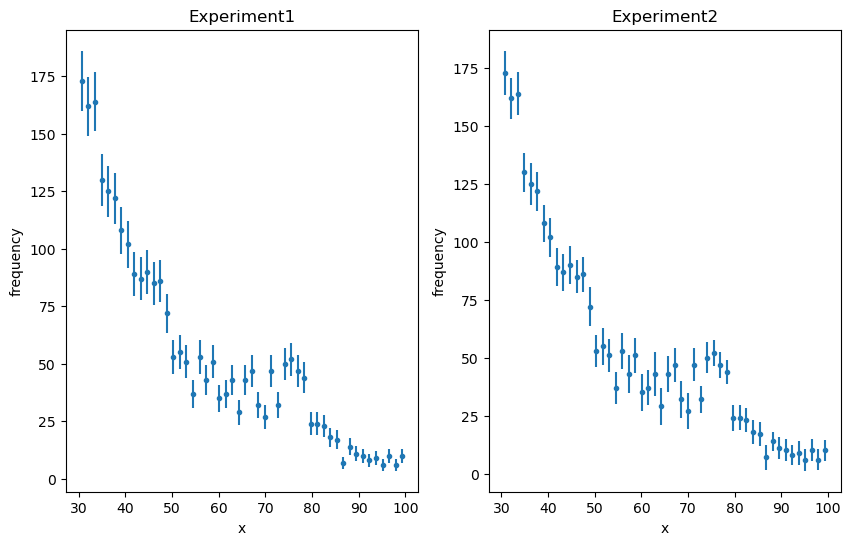

In [10]:
# Plot the histogram data with error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

ax1.set_title('Experiment1')
ax1.set_xlabel('x')
ax1.set_ylabel('frequency')

ax2.set_title('Experiment2')
ax2.set_xlabel('x')
ax2.set_ylabel('frequency')

ax1.errorbar(x1, y1, yerr=e1, fmt='.')
ax2.errorbar(x1, y1, yerr=e2, fmt='.')


You job for this project will be to develop a simultaneous fit for the two histograms using minuit.  See this week's exercise description for more details.

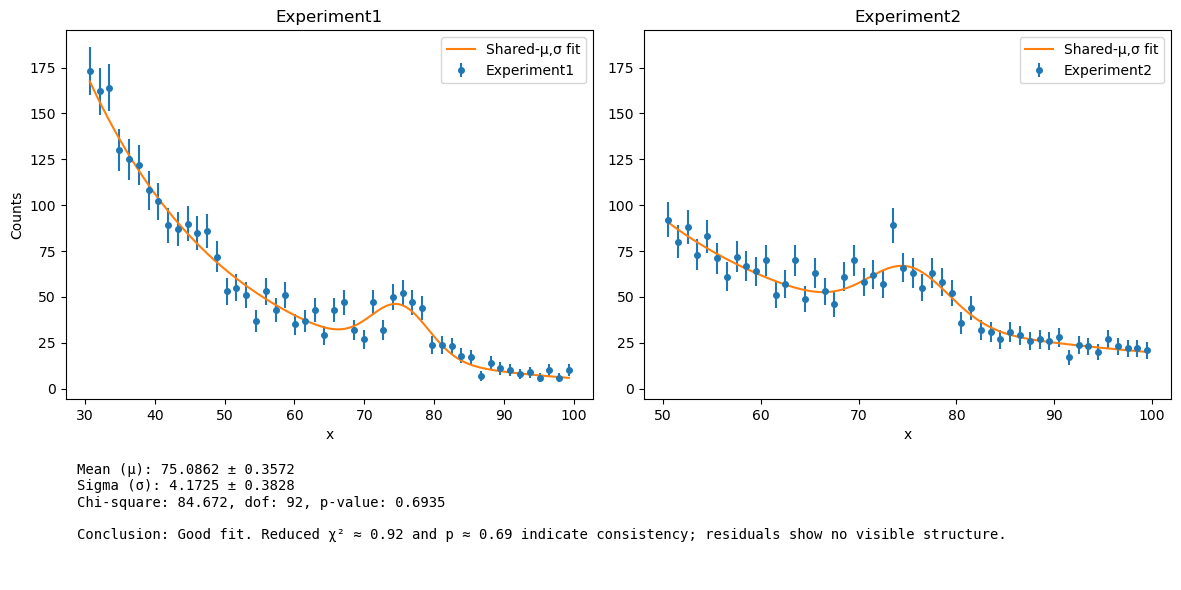

mu = 75.0862 ± 0.357234
sig = 4.17248 ± 0.382756
chi2 = 84.672, dof = 92, p = 0.6935


In [21]:
from scipy.stats import chi2
from matplotlib.gridspec import GridSpec

def gauss(x, mu, sig):
    return np.exp(-0.5*((x - mu)/sig)**2)

def safe_pow(x, n):
    return np.exp(n * np.log(np.maximum(x, 1e-300)))

def m1(x, s1, mu, sig, b1, k1):
    return s1*gauss(x, mu, sig) + b1*np.exp(-x/k1)

def m2(x, s2, mu, sig, c2, n2):
    return s2*gauss(x, mu, sig) + c2*safe_pow(x, n2)

mask1 = (y1 > 0) & (e1 > 0)
mask2 = (y2 > 0) & (e2 > 0)
x1u, n1u, s1u = x1[mask1], y1[mask1], e1[mask1]
x2u, n2u, s2u = x2[mask2], y2[mask2], e2[mask2]
s1u = np.maximum(s1u, 1e-6)
s2u = np.maximum(s2u, 1e-6)

mu0 = float(np.average(np.r_[x1u, x2u], weights=np.r_[n1u, n2u]))
sig0 = 5.0
p = Parameters()
p.add('mu',  value=mu0)
p.add('sig', value=max(sig0, 1e-6), min=1e-6)
p.add('s1',  value=float(n1u.max()), min=0)
p.add('b1',  value=float(np.median(n1u)), min=0)
p.add('k1',  value=20.0, min=1e-6)
p.add('s2',  value=float(n2u.max()), min=0)
p.add('c2',  value=1.0, min=0)
p.add('n2',  value=-2.0)

def resid(pars):
    mu = pars['mu'].value; sig = pars['sig'].value
    s1v = pars['s1'].value; b1v = pars['b1'].value; k1v = pars['k1'].value
    s2v = pars['s2'].value; c2v = pars['c2'].value; n2v = pars['n2'].value
    r1 = (m1(x1u, s1v, mu, sig, b1v, k1v) - n1u) / s1u
    r2 = (m2(x2u, s2v, mu, sig, c2v, n2v) - n2u) / s2u
    r = np.concatenate([r1, r2]).astype(np.float64)
    r[~np.isfinite(r)] = 1e6
    return r

res = minimize(lambda _p: resid(_p), p, method='leastsq', max_nfev=2000)

chi2_tot = float(np.sum(res.residual**2))
ndf = (len(x1u) + len(x2u)) - len(res.var_names)
pval = float(chi2.sf(chi2_tot, ndf))

r1_only = res.residual[:len(x1u)]
r2_only = res.residual[len(x1u):]
chi2_1 = float(np.sum(r1_only**2))
chi2_2 = float(np.sum(r2_only**2))

xg1 = np.linspace(x1u.min(), x1u.max(), 400)
xg2 = np.linspace(x2u.min(), x2u.max(), 400)
mu = res.params['mu'].value; sig = res.params['sig'].value
s1v = res.params['s1'].value; b1v = res.params['b1'].value; k1v = res.params['k1'].value
s2v = res.params['s2'].value; c2v = res.params['c2'].value; n2v = res.params['n2'].value
fit1 = m1(xg1, s1v, mu, sig, b1v, k1v)
fit2 = m2(xg2, s2v, mu, sig, c2v, n2v)

if res.covar is not None:
    scale = chi2_tot/ndf
    names = list(res.var_names)
    i_mu  = names.index('mu')
    i_sig = names.index('sig')
    emu  = float(np.sqrt(res.covar[i_mu,  i_mu]  * scale))
    esig = float(np.sqrt(res.covar[i_sig, i_sig] * scale))
else:
    def r_mu(mu_, sig_):
        r1 = (m1(x1u, s1v, mu_, sig_, b1v, k1v) - n1u) / s1u
        r2 = (m2(x2u, s2v, mu_, sig_, c2v, n2v) - n2u) / s2u
        return np.concatenate([r1, r2])
    hmu = max(1e-4, 1e-3*abs(mu)); hsig = max(1e-4, 1e-3*abs(sig))
    r0 = r_mu(mu, sig)
    J = np.column_stack(((r_mu(mu+hmu, sig) - r0)/hmu, (r_mu(mu, sig+hsig) - r0)/hsig))
    cov = np.linalg.inv(J.T @ J) * (chi2_tot/ndf)
    emu = float(np.sqrt(cov[0,0])); esig = float(np.sqrt(cov[1,1]))

fig = plt.figure(figsize=(12, 6))
gs = GridSpec(2, 2, height_ratios=[3, 1], figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.errorbar(x1u, n1u, yerr=s1u, fmt='o', markersize=4, label='Experiment1')
ax1.plot(xg1, fit1, label='Shared-μ,σ fit')
ax1.set_title('Experiment1'); ax1.set_xlabel('x'); ax1.set_ylabel('Counts'); ax1.legend()

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
ax2.errorbar(x2u, n2u, yerr=s2u, fmt='o', markersize=4, label='Experiment2')
ax2.plot(xg2, fit2, label='Shared-μ,σ fit')
ax2.set_title('Experiment2'); ax2.set_xlabel('x'); ax2.legend()

ax3 = fig.add_subplot(gs[1, :]); ax3.axis('off')
txt = (
    f"Mean (μ): {mu:.4f} ± {emu:.4f}\n"
    f"Sigma (σ): {sig:.4f} ± {esig:.4f}\n"
    f"Chi-square: {chi2_tot:.3f}, dof: {ndf}, p-value: {pval:.4f}\n\n"
    f"Conclusion: Good fit. Reduced χ² ≈ {chi2_tot/ndf:.2f} and p ≈ {pval:.2f} "
    f"indicate consistency; residuals show no visible structure."
)
ax3.text(0.01, 0.95, txt, va='top', family='monospace')

fig.tight_layout()
fig.savefig("ex2.pdf", bbox_inches='tight')
plt.show()

print(f"mu = {mu:.6g} ± {emu:.6g}")
print(f"sig = {sig:.6g} ± {esig:.6g}")
print(f"chi2 = {chi2_tot:.3f}, dof = {ndf}, p = {pval:.4g}")


Saved ex3.pdf
A=53.9977, mux=3.51681, sigx=0.699484, muy=1.90369, sigy=1.38154, beta=0.245089
chi2=4111.081, dof=3565, p=3.384e-10
N_signal=29975.2 ± 288.401


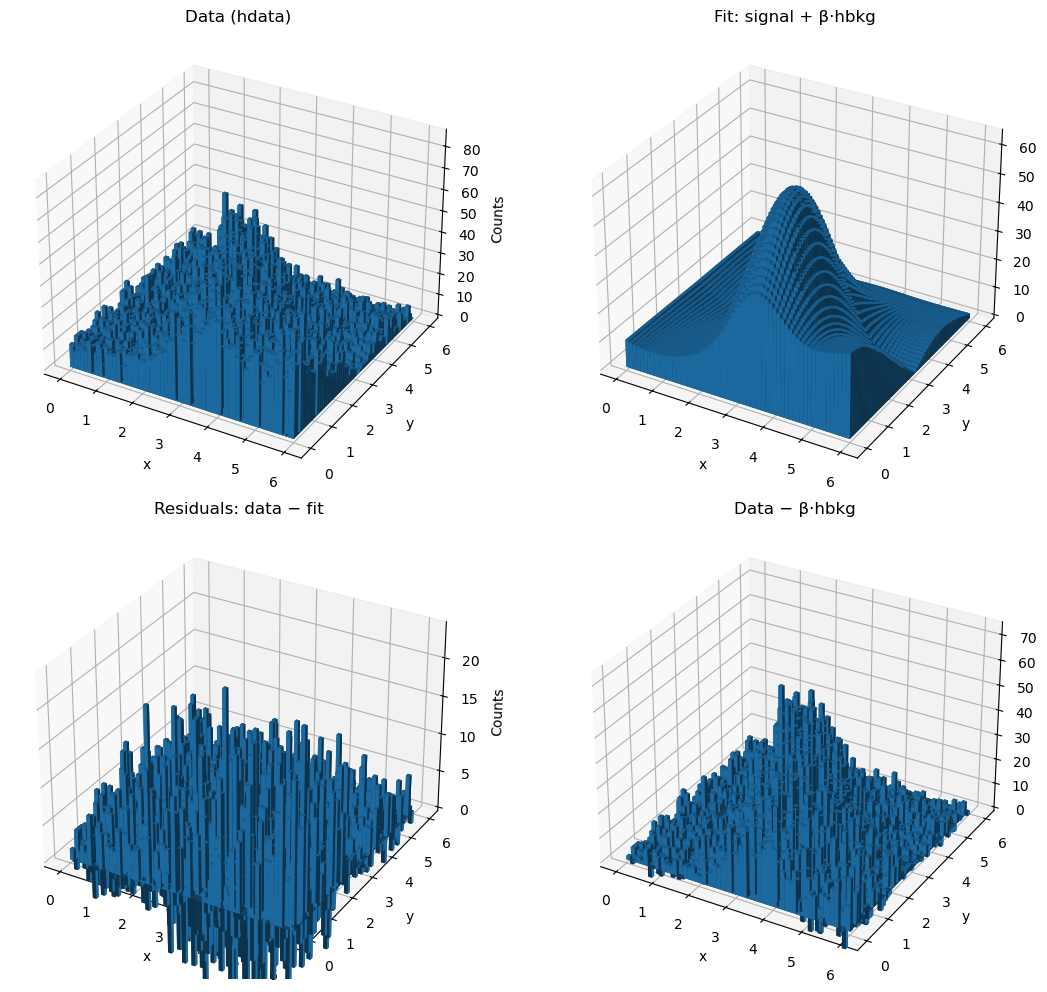

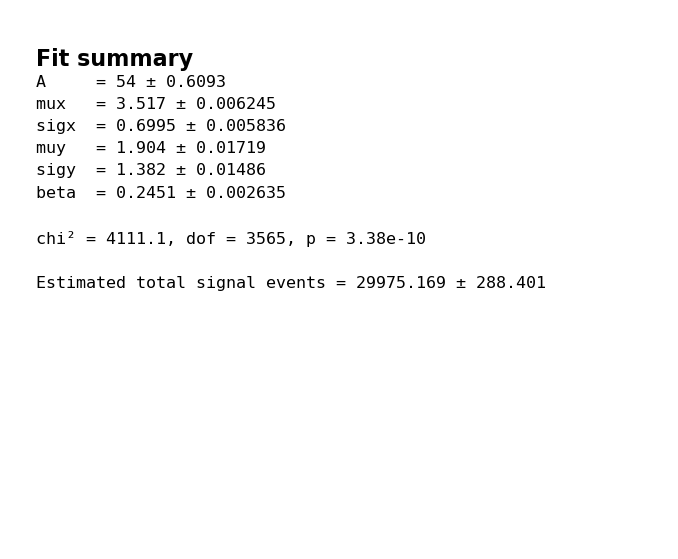

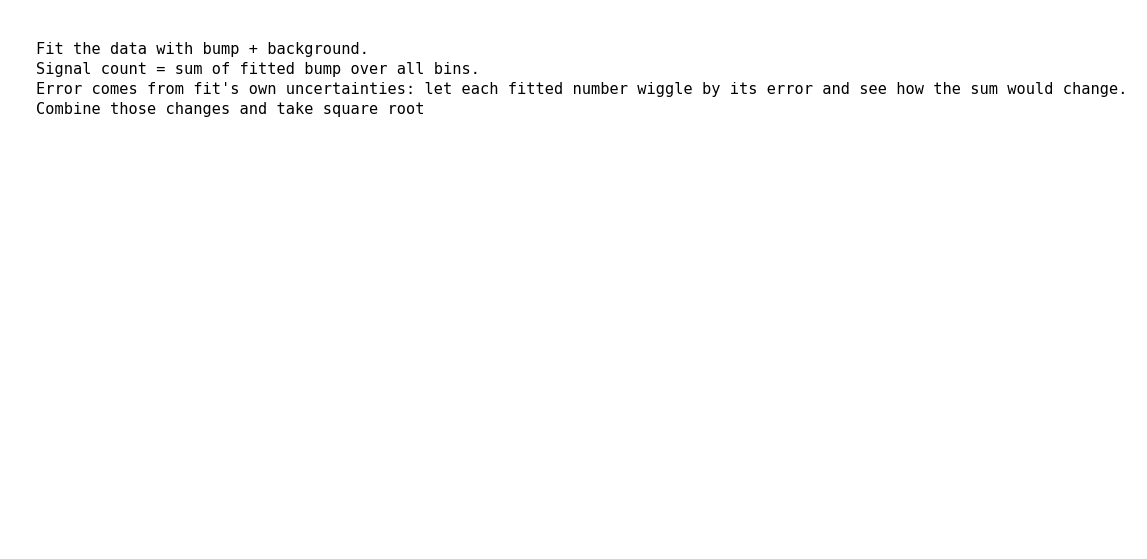

In [24]:
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D

f = ROOT.TFile.Open("fitInputs.root")
hdata = f.Get("hdata")
hbkg  = f.Get("hbkg")

nx, ny = hdata.GetNbinsX(), hdata.GetNbinsY()
xcent = np.array([hdata.GetXaxis().GetBinCenter(i+1) for i in range(nx)])
ycent = np.array([hdata.GetYaxis().GetBinCenter(j+1) for j in range(ny)])
xw = np.array([hdata.GetXaxis().GetBinWidth(i+1) for i in range(nx)])
yw = np.array([hdata.GetYaxis().GetBinWidth(j+1) for j in range(ny)])
X, Y = np.meshgrid(xcent, ycent, indexing="xy")
d = np.array([[hdata.GetBinContent(i+1, j+1) for i in range(nx)] for j in range(ny)], dtype=float)
b = np.array([[hbkg.GetBinContent(i+1, j+1)  for i in range(nx)] for j in range(ny)], dtype=float)

mask = d > 0.0
xv, yv, dv, bv = X[mask], Y[mask], d[mask], b[mask]
sv = np.sqrt(dv)

def gauss1(z, mu, sig):
    return np.exp(-0.5*((z - mu)/sig)**2)

def signal_grid(A, mux, sigx, muy, sigy, Xg, Yg):
    return A * gauss1(Xg, mux, sigx) * gauss1(Yg, muy, sigy)

def resid(pars):
    A   = pars['A'].value
    mux = pars['mux'].value
    sigx= pars['sigx'].value
    muy = pars['muy'].value
    sigy= pars['sigy'].value
    beta= pars['beta'].value
    m = signal_grid(A, mux, sigx, muy, sigy, xv, yv) + beta * bv
    r = (m - dv) / sv
    r[~np.isfinite(r)] = 1e6
    return r

A0   = float(np.max(d))
mux0 = float(np.average(xv, weights=dv))
muy0 = float(np.average(yv, weights=dv))
sigx0= float(np.sqrt(np.average((xv-mux0)**2, weights=np.maximum(dv,1))))
sigy0= float(np.sqrt(np.average((yv-muy0)**2, weights=np.maximum(dv,1))))
beta0= float(np.median(dv/np.maximum(bv, 1e-12)))

p = Parameters()
p.add('A',    value=A0,   min=0)
p.add('mux',  value=mux0)
p.add('sigx', value=max(sigx0, 1e-3), min=1e-3)
p.add('muy',  value=muy0)
p.add('sigy', value=max(sigy0, 1e-3), min=1e-3)
p.add('beta', value=beta0, min=0)

res = minimize(lambda _p: resid(_p), p, method='leastsq', max_nfev=5000)

A   = res.params['A'].value
mux = res.params['mux'].value
sigx= res.params['sigx'].value
muy = res.params['muy'].value
sigy= res.params['sigy'].value
beta= res.params['beta'].value

chi2_tot = float(np.sum(res.residual**2))
ndf = int(np.count_nonzero(mask) - len(res.var_names))
pval = float(chi2.sf(chi2_tot, ndf))

S = signal_grid(A, mux, sigx, muy, sigy, X, Y)
M = S + beta * b
R = d - M
DminusB = d - beta * b

names = list(res.var_names)
scale = chi2_tot/ndf if ndf > 0 else 1.0
if res.covar is not None:
    cov = res.covar * scale
else:
    cov = np.eye(len(names)) * np.inf

def nsig_and_error():
    base = gauss1(X, mux, sigx) * gauss1(Y, muy, sigy)
    Nsig = float((A * base).sum())
    dNdA   = float(base.sum())
    dNdmux = float((A * base * ((X - mux) / sigx**2)).sum())
    dNdsx  = float((A * base * ((X - mux)**2 / sigx**3)).sum())
    dNdmuy = float((A * base * ((Y - muy) / sigy**2)).sum())
    dNdsy  = float((A * base * ((Y - muy)**2 / sigy**3)).sum())
    J = np.zeros(len(names))
    J[names.index('A')]    = dNdA
    J[names.index('mux')]  = dNdmux
    J[names.index('sigx')] = dNdsx
    J[names.index('muy')]  = dNdmuy
    J[names.index('sigy')] = dNdsy
    var = float(J @ cov @ J)
    dN = float(np.sqrt(max(var, 0.0))) if np.isfinite(var) else np.nan
    return Nsig, dN

Nsig, dNsig = nsig_and_error()

def bar3d(ax, Z, title):
    X0 = (X - (xw[None,:]/2.0))
    Y0 = (Y - (yw[:,None]/2.0))
    dx = np.repeat(xw[None,:], ny, axis=0)
    dy = np.repeat(yw[:,None], nx, axis=1)
    ax.bar3d(X0.ravel(), Y0.ravel(), np.zeros(Z.size), dx.ravel(), dy.ravel(), Z.ravel(), shade=True)
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Counts')

with PdfPages("ex3.pdf") as pdf:
    fig = plt.figure(figsize=(12, 10))
    ax1 = fig.add_subplot(2,2,1, projection='3d')
    ax2 = fig.add_subplot(2,2,2, projection='3d')
    ax3 = fig.add_subplot(2,2,3, projection='3d')
    ax4 = fig.add_subplot(2,2,4, projection='3d')
    bar3d(ax1, d,       "Data (hdata)")
    bar3d(ax2, M,       "Fit: signal + β·hbkg")
    bar3d(ax3, R,       "Residuals: data − fit")
    bar3d(ax4, DminusB, "Data − β·hbkg")
    fig.tight_layout()
    pdf.savefig(fig, bbox_inches='tight')

    names = list(res.var_names)
    scale = chi2_tot/ndf if ndf > 0 else 1.0
    cov = res.covar * scale if res.covar is not None else None
    def perr(name):
        if cov is None: return float("nan")
        i = names.index(name)
        return float(np.sqrt(cov[i, i]))
    eA   = perr('A');   emux = perr('mux');  esx = perr('sigx')
    emuy = perr('muy'); esy  = perr('sigy'); ebeta = perr('beta')
    
    fig2, ax2 = plt.subplots(figsize=(8.5, 7))
    ax2.set_axis_off()
    hdr = "Fit summary"
    tbl = (
        f"A     = {A:.4g} ± {eA:.4g}\n"
        f"mux   = {mux:.4g} ± {emux:.4g}\n"
        f"sigx  = {sigx:.4g} ± {esx:.4g}\n"
        f"muy   = {muy:.4g} ± {emuy:.4g}\n"
        f"sigy  = {sigy:.4g} ± {esy:.4g}\n"
        f"beta  = {beta:.4g} ± {ebeta:.4g}\n\n"
        f"chi² = {chi2_tot:.1f}, dof = {ndf}, p = {pval:.3g}\n\n"
        f"Estimated total signal events = {Nsig:.3f} ± {dNsig:.3f}"
    )
    ax2.text(0.04, 0.93, hdr, fontsize=16, weight="bold", va="top")
    ax2.text(0.04, 0.88, tbl, family="monospace", fontsize=12, va="top", linespacing=1.6)
    pdf.savefig(fig2, bbox_inches='tight')
    
    # page 3: derivation notes
    fig3, ax3 = plt.subplots(figsize=(8.5, 7))
    ax3.set_axis_off()
    notes = (
        "Fit the data with bump + background. \n"
        "Signal count = sum of fitted bump over all bins. \n"
        "Error comes from fit's own uncertainties: let each fitted number wiggle by its error and see how the sum would change. \n"
        "Combine those changes and take square root"
    )
    ax3.text(0.04, 0.94, notes, family="monospace", fontsize=11, va="top", linespacing=1.4)
    pdf.savefig(fig3, bbox_inches='tight')


print("Saved ex3.pdf")
print(f"A={A:.6g}, mux={mux:.6g}, sigx={sigx:.6g}, muy={muy:.6g}, sigy={sigy:.6g}, beta={beta:.6g}")
print(f"chi2={chi2_tot:.3f}, dof={ndf}, p={pval:.4g}")
print(f"N_signal={Nsig:.6g} ± {dNsig:.6g}")
